In [1]:
import torch

from importlib import reload

import models
import plotting
import dataloaders as dl
import traintest as tt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
preproc = dl.X_MNIST.view(3000,28,28).mean(dim=0)
preproc_std = torch.ones(28,28)
temp = dl.X_MNIST.view(3000,28,28).std(dim=0)
preproc_std[temp>.1] = temp[temp>.1]
base_model = models.LeNet(preproc=(preproc,preproc_std)).to(device)

In [4]:
import torch.optim as optim

lr = .01
momentum = .9

optimizer_base = optim.SGD(base_model.parameters(), lr=lr, momentum=momentum, weight_decay=0.005)
for epoch in range(20):
    optimizer_base.param_groups[0]['lr'] *= .8
    tt.train(base_model, device, dl.train_loader, optimizer_base, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.293383
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.238598
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.064641
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.093125
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.089759
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.129659
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.074203
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.054367
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.022015
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.072561
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.052406
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.041463
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.045402
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.034100
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.045884
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.034155
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.025293
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.024749
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.025586
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.025845
Train Epoch: 3 [2000

In [5]:
torch.save(base_model, 'base_model.pth')

In [6]:
base_model = torch.load('base_model.pth')
gmm = models.GMM(1000, 784)
gmm.find_solution(dl.X_MNIST, initialize=True, iterate=False, use_kmeans=False)
gmm_model = models.RobustModel(base_model, gmm, -7.).to(device)
torch.save(gmm_model, 'gmm_model.pth')

qmm = models.QuadraticMixtureModel(1000, 784, mu=gmm.mu, logvar=gmm.logvar, alpha=gmm.alpha)
#qmm.find_solution(dl.X_MNIST, initialize=True, iterate=False, use_kmeans=False)
qmm_model = models.RobustModel(base_model, qmm, -7.).to(device)
torch.save(qmm_model, 'qmm_model.pth')

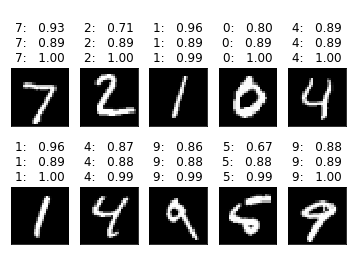




Test set: Average loss: 0.2151, Accuracy: 9667/10000 (97%), Ave. Confidence: 83%


Test set: Average loss: 0.1478, Accuracy: 9859/10000 (99%), Ave. Confidence: 88%


Test set: Average loss: 0.0349, Accuracy: 9877/10000 (99%), Ave. Confidence: 98%


Ave. Confidence: 50% Predicted: 47%


Ave. Confidence: 71% Predicted: 82%


Ave. Confidence: 79% Predicted: 88%



0.7899127976481731

In [7]:
#gmm_model.loglam.data = torch.tensor(-8., device=device)
qmm_model.loglam.data = torch.tensor(-2., device=device)

data = enumerate(dl.test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
yq = qmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, yq, y_base], data)

min_conf = .5
tt.test(gmm_model, device, dl.test_loader, min_conf=min_conf)
tt.test(qmm_model, device, dl.test_loader, min_conf=min_conf)
tt.test(base_model, device, dl.test_loader, min_conf=min_conf)

tt.test_adv(gmm_model, device, dl.EMNIST_test_loader, min_conf=min_conf)
tt.test_adv(qmm_model, device, dl.EMNIST_test_loader, min_conf=min_conf)
tt.test_adv(base_model, device, dl.EMNIST_test_loader, min_conf=min_conf)

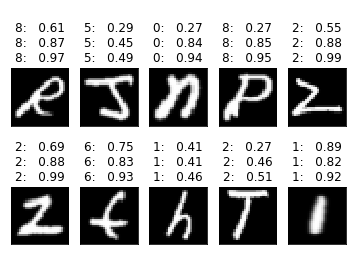

In [8]:
data = enumerate(dl.EMNIST_test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
yq = qmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, yq, y_base], data)